In [1]:
import gym
from vaiutils import plot_image, path_consts
from scipy.misc import imresize
from time import time
from tqdm import tqdm_notebook
from os.path import exists

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten
from keras.backend import clear_session

Using TensorFlow backend.


In [3]:
for k, v in path_consts('Pong-ES'):
    exec(k + '=v')

In [4]:
env = gym.make('Pong-v0')

[2017-09-10 07:36:52,251] Making new env: Pong-v0


In [5]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [6]:
def norm_action(action):
    if action == 0 or action == 1:
        return 0
    elif action == 2 or action == 4:
        return 1
    elif action == 3 or action == 5:
        return 2

In [7]:
def denorm_action(action):
    if action == 0:
        return 0
    else:
        return action + 1

In [8]:
def meaning(normed_action):
    if normed_action == 0:
        return 'Nothing'
    elif normed_action == 1:
        return 'Up'
    elif normed_action == 2:
        return 'Down'

In [9]:
def refine_observation(observation):
    res_img = observation[34:192, 1:-1].mean(2)
    res_img[res_img < 100] = 0
    res_img[res_img > 100] = 255

    white_pos = np.where(res_img == 255)
    l_cols = (white_pos[1] > 14) & (white_pos[1] < 19)
    if np.any(l_cols):
        l_y = white_pos[0][np.where(l_cols)].mean()
    else:
        l_y = 0

    r_cols = (white_pos[1] > 138) & (white_pos[1] < 143)
    if np.any(r_cols):
        r_y = white_pos[0][np.where(r_cols)].mean()
    else:
        r_y = 0

    b_cols = ~l_cols & ~r_cols
    if np.any(b_cols):
        b_x = white_pos[1][np.where(b_cols)].mean()
        b_y = white_pos[0][np.where(b_cols)].mean()
    else:
        b_x = 0
        b_y = 0

    return np.array([l_y, r_y, b_x, b_y]) / 79 - 1

In [10]:
def paint_observation(refined_observation):
    obs = (refined_observation + 1) * 79
    obs_centre = np.ceil(obs).astype('int')
    
    img = np.zeros((158,158))
    
    l_y_l, r_y_l, b_x_l, b_y_l = np.maximum(0, obs_centre-[8,8,1,2])
    l_y_h, r_y_h, b_x_h, b_y_h = np.minimum(158, obs_centre+[8,8,1,2])
    
    img[l_y_l:l_y_h, 15:19] = 255
    img[r_y_l:r_y_h, 139:143] = 255
    img[b_y_l:b_y_h, b_x_l:b_x_h] = 255
    return img

In [106]:
clear_session()
model = Sequential([Dense(3, input_shape=[4], activation='softmax')])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [75]:
def get_weights(model):
    weight_list = []
    for layer in model.layers:
        if layer.trainable:
            for w in layer.get_weights():
                weight_list += list(w.reshape(-1))
    return np.stack(weight_list)

In [13]:
def set_weights(model, weights):
    idx = 0
    for layer in model.layers:
        if layer.trainable:
            layer_weight_length = layer.count_params()
            if layer_weight_length == 0:
                continue
            layer_weights = weights[idx:idx + layer_weight_length]
            idx += layer_weight_length

            layer_idx = 0
            weight_params = []
            for w in layer.get_weights():
                weight_params.append(
                    layer_weights[layer_idx:layer_idx + w.size].reshape(w.shape))
                layer_idx += w.size

            layer.set_weights(weight_params)

In [65]:
def run_env(model, num_points=-1, flags=[]):
    points_played = 0
    reward = 0
    start_time = time()

    observation = env.reset()
    steps = 0
    while True:
        if 'render' in flags:
            env.render()
        #action = (model.predict(refine_observation(
            #observation)[1::2][np.newaxis, :]) > 0.5).astype('int') + 1
        action = np.random.choice(range(3), p=model.predict(refine_observation(
            observation)[np.newaxis, :])[0])
        observation, r, done, _ = env.step(denorm_action(action))
        if r != 0:
            reward += r * (1 + 100/(1+steps/10))
            steps = 0
        steps += 1
        if 'verbose' in flags:
            print("Point:{}, Reward: {}, Action: {}, Time: {}s".format(
                1 + points_played, np.round(reward / (1 + points_played), 2), meaning(action), int(time() - start_time)), end='\r', flush=True)
        if r != 0:
            points_played += 1
            if points_played == num_points:
                break

        if done:
            break

    return reward / points_played

In [105]:
def evolve(model, epochs=1, duration=np.inf, population_size=50, sigma=1e-1, lr=1e-3, num_points=-1, flags=[]):
    num_weights = model.count_params()
    start_time = time()
    weights = get_weights(model)
    if 'reward_list' in flags:
        reward_list = [(0, time() - start_time, run_env(model, num_points))]

    if 'verbose' in flags:
        epoch_iterator = tqdm_notebook(range(epochs))
    else:
        epoch_iterator = range(epochs)

    for epoch in epoch_iterator:
        jitters = np.random.randn(population_size, num_weights)
        rewards = np.zeros(population_size)

        if 'verbose' in flags:
            iterator = enumerate(tqdm_notebook(jitters))
        else:
            iterator = enumerate(jitters)

        for i, epsilon in iterator:
            w = weights + sigma * epsilon
            set_weights(model, w)
            rewards[i] = run_env(model, num_points)

        if rewards.std() == 0:
            print("No improvement!")
            sigma *= 1.5
            set_weights(model, weights)
            continue

        normed_rewards = (rewards - rewards.mean()) / rewards.std()
        #weights += lr * rewards.T.dot(normed_rewards) / (population_size * sigma)
        weights += sigma * jitters[rewards.argmax()]
        set_weights(model, weights)
        model.save_weights(DIR_OUTPUT + '/weights.h5')

        if 'reward_list' in flags:
            reward_list.append((epoch, time() - start_time,
                                run_env(model, num_points)))
            if 'verbose' in flags:
                print("Epoch: {}, Time: {}s, Reward: {}".format(
                    epoch, int(reward_list[-1][1]), reward_list[-1][2]))
                print("Population Reward: min={}, max={}".format(
                    rewards.min(), rewards.max()))
        elif 'verbose' in flags:
            print("Epoch: {}, Time: {}s, Reward: {}".format(
                epoch, int(time() - start_time), run_env(model, num_points)))
            print("Population Reward: min={}, max={}".format(
                rewards.min(), rewards.max()))

        if time() - start_time > duration:
            break

    return_dict = {}
    if 'reward_list' in flags:
        return_dict['reward_list'] = reward_list
    return return_dict

In [ ]:
if exists(DIR_OUTPUT + '/weights.h5'):
    model.load_weights(DIR_OUTPUT + '/weights.h5')
return_dict = evolve(model, 10, lr=1e-2, num_points=5, flags=['verbose', 'reward_list'])
if exists(DIR_OUTPUT + '/weights.h5'):
    model.load_weights(DIR_OUTPUT + '/weights.h5')

Epoch: 0, Time: 20s, Reward: -16.21101604586178
Population Reward: min=-17.817969264777776, max=-11.579502508807517


Epoch: 1, Time: 42s, Reward: -16.07422187049367
Population Reward: min=-17.709966263094366, max=-9.277684214660683


Epoch: 2, Time: 62s, Reward: -17.22669566978883
Population Reward: min=-17.950244397052906, max=-11.387946655807799


Epoch: 3, Time: 84s, Reward: -17.252720992490328
Population Reward: min=-17.768414150489626, max=-7.911691264683053


Epoch: 4, Time: 105s, Reward: -17.80468012185317
Population Reward: min=-17.63574054066414, max=-9.624377910750653


Epoch: 5, Time: 126s, Reward: -11.698057987933758
Population Reward: min=-17.677055285302707, max=-10.601206690494934


Epoch: 6, Time: 147s, Reward: -17.05017773427438
Population Reward: min=-17.639723606644814, max=-11.8218571639182


Epoch: 7, Time: 168s, Reward: -17.00280298204866
Population Reward: min=-17.58578263841422, max=-9.904892769711534


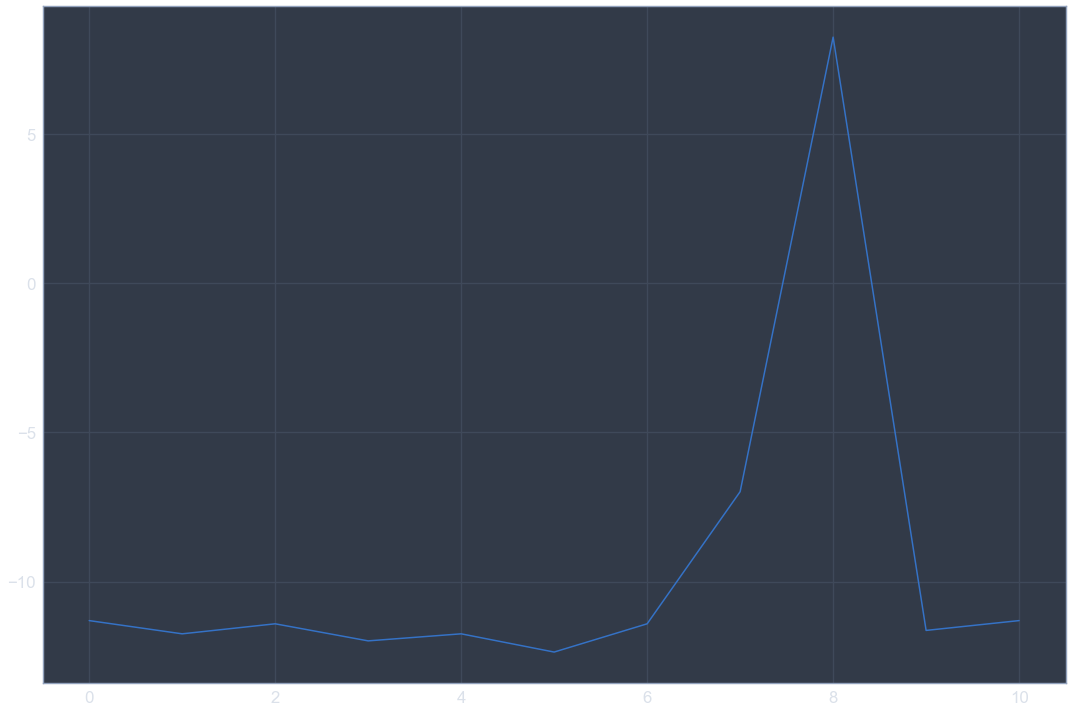

In [102]:
plot(np.array(return_dict['reward_list'])[:, 2])

In [104]:
print(get_weights(model))
run_env(model, 5, flags=['render'])

[ 0.02204714  1.19430029  1.24257946 -0.16077097 -0.44420281 -0.40516499
 -0.58168775  0.51342285  0.66896552  0.38573143 -0.39244476  0.1321023
  0.33432677  0.33432677  0.33432677]


-17.505577205561778